<a href="https://www.kaggle.com/code/kazimjawad/flood-tweets-sentiment-analysis-pakistan-2022?scriptVersionId=108761377" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Importing Libraries

In [1]:
import re
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import gensim
!pip install tweet-preprocessor
import preprocessor as p

from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# EDA

In [2]:
df = pd.read_csv('../input/floods-in-pakistan-2022-tweets-dataset/FloodsInPakistan-tweets.csv')
print(df.shape)
df.head()

(1000, 28)


,url,date,content,renderedContent,id,user,replyCount,retweetCount,likeCount,quoteCount,...,retweetedTweet,quotedTweet,inReplyToTweetId,inReplyToUser,mentionedUsers,coordinates,place,hashtags,cashtags,card
0,https://twitter.com/AliBhattiPPP/status/156978...,2022-09-13 20:16:16+00:00,PPP MNA @DRMAHREENBHUTTO visited the free Medi...,PPP MNA @DRMAHREENBHUTTO visited the free Medi...,1569782031747530752,"{'username': 'AliBhattiPPP', 'id': 14081030369...",0,2,3,0,...,NaN,NaN,NaN,NaN,"[{'username': 'DRMAHREENBHUTTO', 'id': 9429406...",NaN,NaN,"['Larkana', 'FloodsInPakistan']",NaN,NaN
1,https://twitter.com/HullioSikandar/status/1569...,2022-09-13 20:09:43+00:00,Sindh Local Govt Minister @SyedNasirHShah says...,Sindh Local Govt Minister @SyedNasirHShah says...,1569780384342196226,"{'username': 'HullioSikandar', 'id': 448669571...",1,3,5,0,...,NaN,NaN,NaN,NaN,"[{'username': 'SyedNasirHShah', 'id': 32975770...",NaN,NaN,['FloodsInPakistan'],NaN,NaN
2,https://twitter.com/gnnhdofficial/status/15697...,2022-09-13 20:00:00+00:00,یو این ایچ سی آر کے 2 طیارے بھی مزید امدادی سا...,یو این ایچ سی آر کے 2 طیارے بھی مزید امدادی سا...,1569777939855847425,"{'username': 'gnnhdofficial', 'id': 492154297,...",0,1,0,0,...,NaN,NaN,NaN,NaN,"[{'username': 'Refugees', 'id': 14361155, 'dis...",NaN,NaN,"['FloodsInPakistan2022', 'FloodsInPakistan', '...",NaN,NaN
3,https://twitter.com/gtvnetworkhd/status/156977...,2022-09-13 20:00:00+00:00,پاکستان کے لیے امداد کا اعلان کیا ہے ، ڈونلڈ ب...,پاکستان کے لیے امداد کا اعلان کیا ہے ، ڈونلڈ ب...,1569777939746590726,"{'username': 'gtvnetworkhd', 'id': 3842393182,...",0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['DonaldBlome', 'USAAmbassy', 'FloodsInPakista...",NaN,NaN
4,https://twitter.com/iqleyaa/status/15697772963...,2022-09-13 19:57:27+00:00,We are raising funds for:\n\n•Food parcels= £3...,We are raising funds for:\n\n•Food parcels= £3...,1569777296344481793,"{'username': 'iqleyaa', 'id': 1512896744203427...",0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['FloodsInPakistan', 'Pk', 'PakistanFloods2022...",NaN,{'title': 'Team H&K & Al-Akhirah Pakistan Floo...


In [3]:
df.describe()

,id,replyCount,retweetCount,likeCount,quoteCount,conversationId,retweetedTweet,inReplyToTweetId,cashtags
count,1.000000e+03,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,0.0,8.300000e+01,0.0
mean,1.569659e+18,0.286000,2.315000,7.137000,0.087000,1.554456e+18,NaN,1.569571e+18,NaN
std,5.788190e+13,1.090593,10.655201,42.597779,0.399488,1.055949e+17,NaN,1.613629e+14,NaN
min,1.569554e+18,0.000000,0.000000,0.000000,0.000000,5.382641e+17,NaN,1.568741e+18,NaN
25%,1.569615e+18,0.000000,0.000000,0.000000,0.000000,1.569608e+18,NaN,1.569579e+18,NaN
50%,1.569658e+18,0.000000,0.000000,0.000000,0.000000,1.569651e+18,NaN,1.569619e+18,NaN
75%,1.569688e+18,0.000000,1.000000,3.000000,0.000000,1.569687e+18,NaN,1.569642e+18,NaN
max,1.569782e+18,13.000000,170.000000,935.000000,5.000000,1.569782e+18,NaN,1.569766e+18,NaN


In [4]:
df.isnull().sum()

url                    0
date                   0
content                0
renderedContent        0
id                     0
user                   0
replyCount             0
retweetCount           0
likeCount              0
quoteCount             0
conversationId         0
lang                   0
source                 0
sourceUrl              0
sourceLabel            0
outlinks             697
tcooutlinks          697
media                481
retweetedTweet      1000
quotedTweet          889
inReplyToTweetId     917
inReplyToUser        917
mentionedUsers       779
coordinates          972
place                972
hashtags               0
cashtags            1000
card                 910
dtype: int64

array([[<AxesSubplot:title={'center':'id'}>,
        <AxesSubplot:title={'center':'replyCount'}>,
        <AxesSubplot:title={'center':'retweetCount'}>],
       [<AxesSubplot:title={'center':'likeCount'}>,
        <AxesSubplot:title={'center':'quoteCount'}>,
        <AxesSubplot:title={'center':'conversationId'}>],
       [<AxesSubplot:title={'center':'retweetedTweet'}>,
        <AxesSubplot:title={'center':'inReplyToTweetId'}>,
        <AxesSubplot:title={'center':'cashtags'}>]], dtype=object)

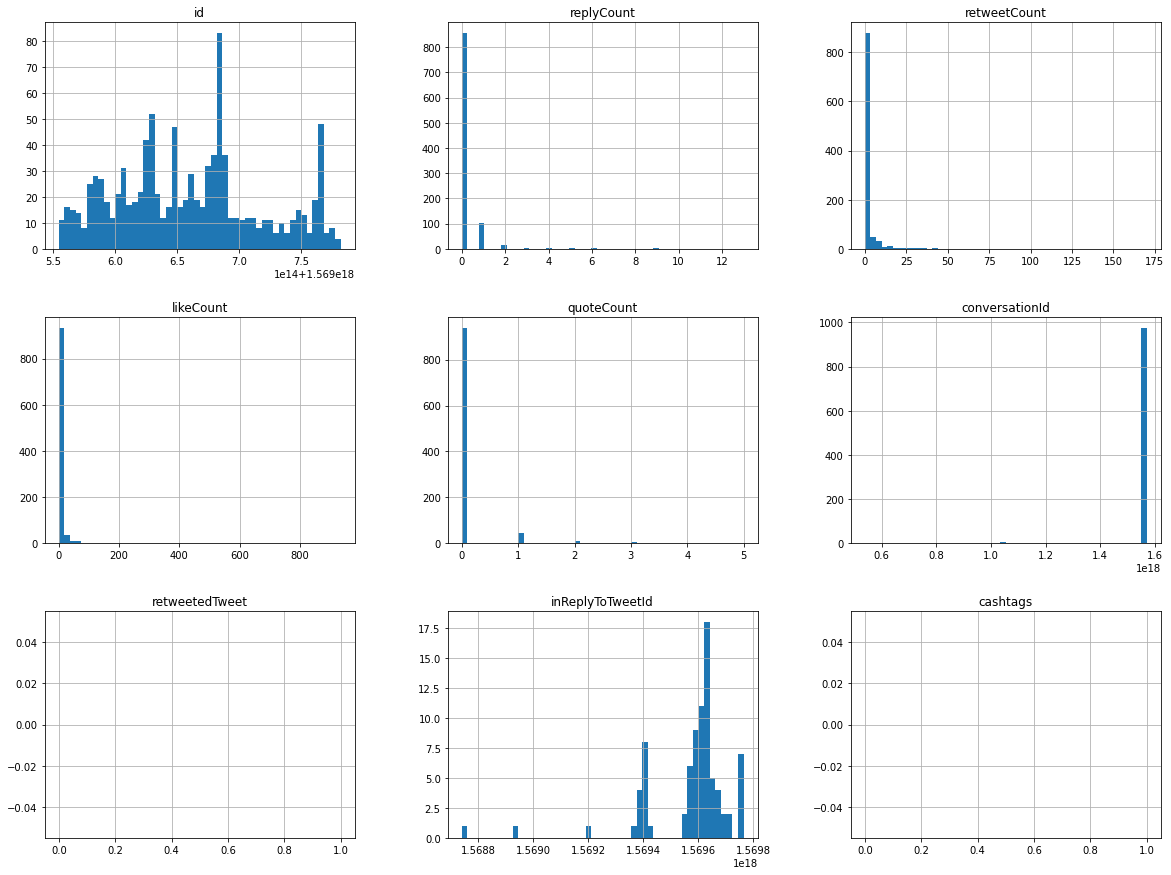

In [5]:
df.hist(bins=50, figsize=(20, 15))

# Exploration of the Hashtags

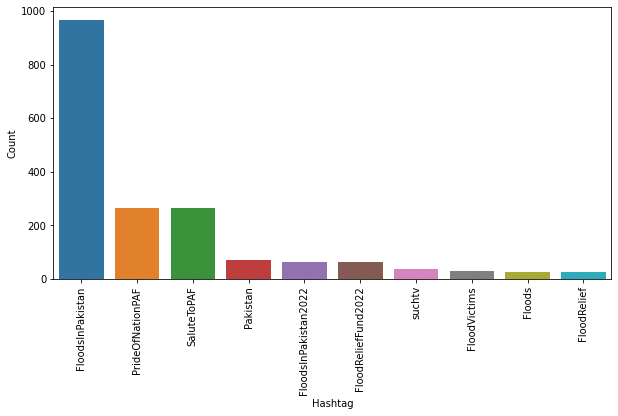

In [6]:
def hashtag_extract(x):
    hashtags = []
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)
    return hashtags
HT_regular = hashtag_extract(df['content'])
HT_regular = sum(HT_regular,[])
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})

# selecting top 20 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 

plt.figure(figsize=(10,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
plt.xticks(rotation=90)
ax.set(ylabel = 'Count')
plt.show()

# Initial Preprocessing

In [7]:
# remove stopwords:
df['content'] = df['content'].apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords.words('english')]))

# remove punctuation:
df['content'] = df['content'].str.replace('[^\w\s]','')

# remove whitespace from df['text']:
df['content'] = df['content'].apply(lambda x:' '.join(x.split()))

#  remove extra whitespace:
df['content'] = df['content'].str.strip()

# convert all text to lowercase:
df['content'] = df['content'].apply(lambda x: x.lower())


df['content']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """


0      ppp mna drmahreenbhutto visited free medical c...
1      sindh local govt minister syednasirhshah says ...
2      یو این ایچ سی آر کے 2 طیارے بھی مزید امدادی سا...
3      پاکستان کے لیے امداد کا اعلان کیا ہے ڈونلڈ بلو...
4      we raising funds for food parcels 30 hot meals...
                             ...                        
995    saudiarabia launched national campaign named s...
996    پاکستان کے سیلاب متاثرین کے لیے 9 ممالک اور 3 ...
997    turkia turkey pakistan floodsinpakistan floodr...
998    zaahidbaloch athar_joya heart wrenching fighti...
999    danguefever mosquito fever floodsinpakistan ht...
Name: content, Length: 1000, dtype: object

## Remove Duplicate Tweets


In [8]:
df.drop_duplicates(subset='content', keep="first", inplace = True)
len(df)

971

In [9]:
df['content']

0      ppp mna drmahreenbhutto visited free medical c...
1      sindh local govt minister syednasirhshah says ...
2      یو این ایچ سی آر کے 2 طیارے بھی مزید امدادی سا...
3      پاکستان کے لیے امداد کا اعلان کیا ہے ڈونلڈ بلو...
4      we raising funds for food parcels 30 hot meals...
                             ...                        
995    saudiarabia launched national campaign named s...
996    پاکستان کے سیلاب متاثرین کے لیے 9 ممالک اور 3 ...
997    turkia turkey pakistan floodsinpakistan floodr...
998    zaahidbaloch athar_joya heart wrenching fighti...
999    danguefever mosquito fever floodsinpakistan ht...
Name: content, Length: 971, dtype: object

# Clean tweet text with tweet-preprocessor


In [10]:
import preprocessor as p
df['content'] = df['content'].apply(lambda x: p.clean(x))
df['content']

0      ppp mna drmahreenbhutto visited free medical c...
1      sindh local govt minister syednasirhshah says ...
2      refugees floodsinpakistan2022 floodsinpakistan...
3      donaldblome usaambassy floodsinpakistan gtvnew...
4      we raising funds for food parcels hot meals te...
                             ...                        
995    saudiarabia launched national campaign named s...
996    httpstcohfa1jaioux pakistan floodsinpakistan f...
997    turkia turkey pakistan floodsinpakistan floodr...
998    zaahidbaloch athar_joya heart wrenching fighti...
999    danguefever mosquito fever floodsinpakistan ht...
Name: content, Length: 971, dtype: object

# Creation of the wordcloud

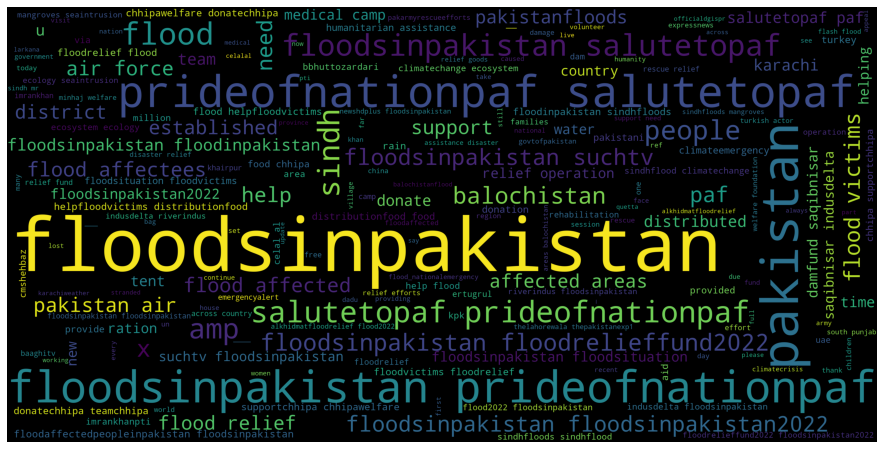

In [11]:
df['content'] = df['content'].fillna("").astype('str')
title_corpus = ' '.join(df['content'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000).generate(title_corpus)
# Plot the wordcloud
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

# Sentiment Analysis

In [12]:
sa = SentimentIntensityAnalyzer()
df['nltk_scores'] = df['content'].apply(lambda x: sa.polarity_scores(x))

# Obtaining NLTK compound score
df['nltk_cmp_score'] = df['nltk_scores'].apply(lambda score_dict: score_dict['compound'])
# Set threshold to define neutral sentiment
neutral_thresh = 0.05

In [13]:
df['nltk_sentiment'] = df['nltk_cmp_score'].apply(lambda c: 'Positive' if c >= neutral_thresh else ('Negative' if c <= -(neutral_thresh) else 'Neutral'))
df['nltk_cmp_score'].describe()

count    971.000000
mean       0.087595
std        0.335985
min       -0.944600
25%        0.000000
50%        0.000000
75%        0.226300
max        0.959500
Name: nltk_cmp_score, dtype: float64

Neutral     577
Positive    273
Negative    121
Name: nltk_sentiment, dtype: int64


(array([0, 1, 2]),
 [Text(0, 0, 'Neutral'), Text(1, 0, 'Positive'), Text(2, 0, 'Negative')])

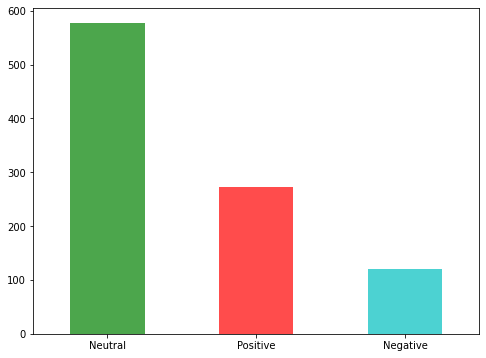

In [14]:
sent =['positive','Negative','Neutral']
con = [1196, 120,100]
print(df['nltk_sentiment'].value_counts())
plt.figure(figsize = (8,6))
df.nltk_sentiment.value_counts().plot(kind ='bar', color =['g','r','c'], alpha = 0.7)
plt.xticks(rotation=0)

In [15]:
X = df['content']
y = df['nltk_cmp_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
#vectorizing text data into tfidf features
tfidf_vectorizer = TfidfVectorizer()
X_train = tfidf_vectorizer.fit_transform(X_train)
X_test = tfidf_vectorizer.transform(X_test)
#fitting linear regression model
regressor = LinearRegression()
regressor.fit(X_train, y_train)
#predicting test set results
y_pred = regressor.predict(X_test)
#evaluating r2_score
r2_score(y_test, y_pred)
#evaluating mae
mae1 = mean_absolute_error(y_test, y_pred)
#evaluating mse
mse1 = mean_squared_error(y_test, y_pred)
#evaluating rmse
rmse1 = np.sqrt(mse1)

In [16]:
#displaying the results for the Linear Regression Model
print('Mean Absolute Error:', mae1)  
print('Mean Squared Error:', mse1)  
print('Root Mean Squared Error:', rmse1)

Mean Absolute Error: 0.14216799423456125
Mean Squared Error: 0.05720317773410608
Root Mean Squared Error: 0.23917185815665287


In [17]:
rf = RandomForestRegressor(n_estimators = 100, random_state = 42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
r2_score(y_test, y_pred)
mae2 = mean_absolute_error(y_test, y_pred)
mse2 = mean_squared_error(y_test, y_pred)
rmse2 = np.sqrt(mse2)

In [18]:
#displaying the results for the Random Forest Model
print('Mean Absolute Error:', mae2)  
print('Mean Squared Error:', mse2)  
print('Root Mean Squared Error:', rmse2)

Mean Absolute Error: 0.12272528717948719
Mean Squared Error: 0.052546173231892306
Root Mean Squared Error: 0.22922952085604573


# Comparing the Linear Regression Model with the Random Forest Model


In [19]:
d1 = pd.DataFrame({"Model":["Linear Regression","XGBoost"],"MAE":[mae1,mae2],"MSE":[mse1,mse2],"RMSE":[rmse1,rmse2]})
d1.style.background_gradient(cmap='Greens')

,Model,MAE,MSE,RMSE
0,Linear Regression,0.142168,0.057203,0.239172
1,XGBoost,0.122725,0.052546,0.229230


# Word2Vec

In [20]:
tokenized_tweet = df['content'].apply(lambda x: x.split()) 

# creating a word to vector model
model_w2v = gensim.models.Word2Vec(
            tokenized_tweet,
            window=5, # context window size
            min_count=2,
            sg = 1, # 1 for skip-gram model
            hs = 0,
            negative = 10, # for negative sampling
            workers= 2, # no.of cores
            seed = 34)

model_w2v.train(tokenized_tweet, total_examples= len(df['content']), epochs=20)

(138036, 236420)

In [21]:
model_w2v.wv.most_similar(positive = "flood")

[('distribution', 0.7711427807807922),
 ('collect', 0.7710556983947754),
 ('received', 0.7552670836448669),
 ('activities', 0.7385431528091431),
 ('rs25000', 0.7361358404159546),
 ('under', 0.7299222350120544),
 ('launches', 0.7266693115234375),
 ('appeal', 0.7250802516937256),
 ('digital', 0.7248926162719727),
 ('yousuf', 0.7236257195472717)]